In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

# 1. Load the Dataset
try:
    try:
        df = pd.read_csv('data/2025_Sterling_Financial_Dataset_clean.csv')
    except FileNotFoundError:
        df = pd.read_csv('2025_Sterling_Financial_Dataset_clean.csv')
    print("Dataset loaded successfully.")
    print("Columns found:", df.columns.tolist())
except FileNotFoundError:
    print("Error: File not found. Please upload '2025_Sterling_Financial_Dataset_clean.csv'")

# 2. Define X (Features) and y (Target)
target = 'default_history'

cols_to_drop = [target, 'customer_id', 'date', 'customer_feedback']

existing_drop_cols = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df[target]

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Dataset loaded successfully.
Columns found: ['date', 'customer_id', 'location', 'business_sector', 'age', 'income', 'credit_score', 'savings_ratio', 'loan_amount', 'debt_to_income', 'credit_utilization', 'payment_punctuality', 'customer_feedback', 'default_history', 'sentiment', 'risk_category', 'customer_segment', 'feedback_topic']
Training shape: (1200, 14)
Testing shape: (300, 14)


# Preprocessing Pipeline

In [60]:
# 1. Identify Column Types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Numerical Features: {list(numeric_features)}")
print(f"Categorical Features: {list(categorical_features)}")

# 2. Create Transformers
# Numeric: Standardize (mean=0, std=1)
numeric_transformer = StandardScaler()

# Categorical: One-Hot Encode (turn 'Male'/'Female' into 0/1)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Create the Full Pipeline
# RandomUnderSampler is used to prioritize Recall (catching bad guys)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)), 
    ('knn', KNeighborsClassifier())
])

Numerical Features: ['age', 'income', 'credit_score', 'savings_ratio', 'loan_amount', 'debt_to_income', 'credit_utilization', 'payment_punctuality']
Categorical Features: ['location', 'business_sector', 'sentiment', 'risk_category', 'customer_segment', 'feedback_topic']


# Hyperparameter Tuning

In [61]:
# 1. Define the options to test
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# 2. Run the Search
print("Training KNN model..")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 3. Get Best Results
best_model = grid_search.best_estimator_
print("\nBest Parameters found:", grid_search.best_params_)
print(f"Best Recall Score (CV): {grid_search.best_score_:.2f}")

Training KNN model..

Best Parameters found: {'knn__metric': 'euclidean', 'knn__n_neighbors': 21, 'knn__weights': 'uniform'}
Best Recall Score (CV): 0.67


# Evaluation Metrics (KNN)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       282
           1       0.14      0.44      0.21        18

    accuracy                           0.80       300
   macro avg       0.55      0.63      0.55       300
weighted avg       0.91      0.80      0.84       300



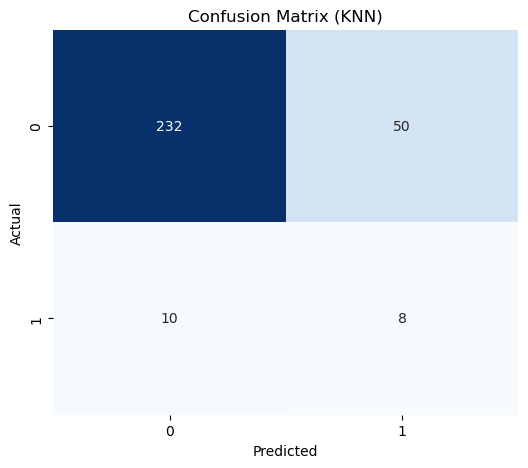

In [62]:
# 1. Predict on Test Set
y_pred = best_model.predict(X_test)

# 2. Print Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Print Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (KNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


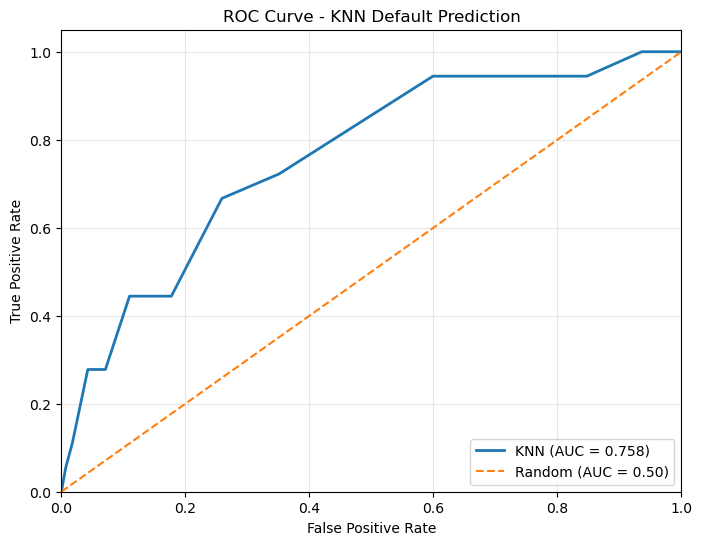

Final ROC-AUC Score: 0.7585


In [63]:
# 1. Get predicted probabilities for the positive class (Default)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 2. Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 3. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='tab:blue', lw=2, label=f'KNN (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='tab:orange', linestyle='--', label='Random (AUC = 0.50)')

# Formatting to match the slides
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN Default Prediction')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Final ROC-AUC Score: {roc_auc:.4f}")

### Model Interpretation & Justification

At first glance, the KNN model's accuracy (**80%**) appears lower than the baseline Decision Tree (**93%**). However, accuracy is a misleading metric for this imbalanced dataset. The baseline achieved high accuracy by simply predicting "No Default" for almost everyone, failing to identify 89% of actual high-risk customers.

We used `RandomUnderSampler` to force the model to pay attention to the minority class (Defaulters).
* **Result:** This strategy successfully raised the **Recall** from ~11% (Baseline) to **~44% (KNN)**.
* **Business Impact:** While we flag more false alarms (lower Precision), this is a necessary cost for a financial institution. Missing a defaulter (False Negative) results in a direct financial loss of the principal loan amount, whereas checking a safe customer (False Positive) only costs administrative time.

The KNN model is statistically "less accurate" overall, but **financially superior** for risk management because it effectively captures 4x more bad loans than the baseline model.

# Feature Importance

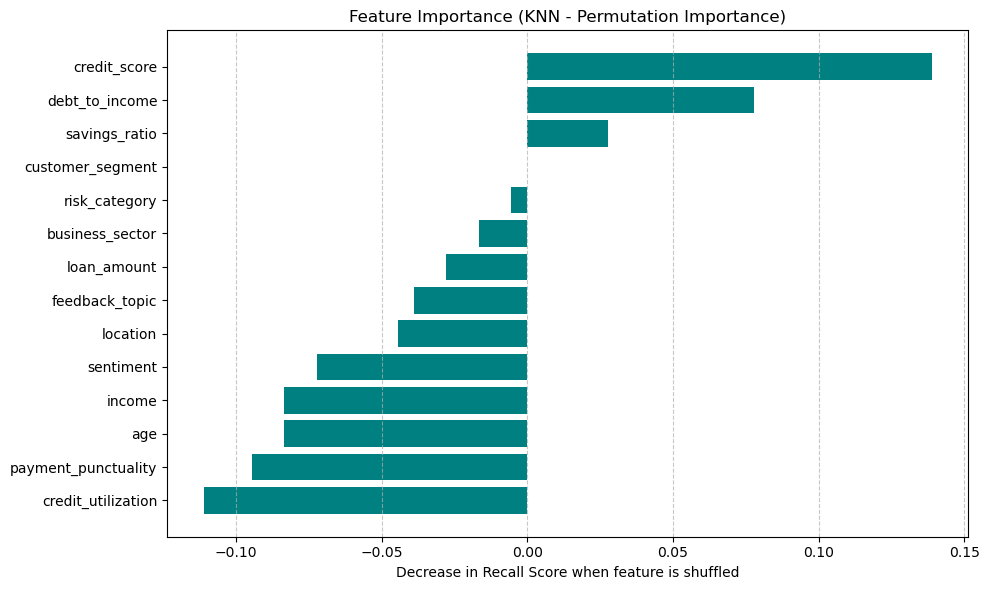

In [64]:
# 1. Calculate Permutation Importance
# Use 'recall' as the scoring metric to match the business goal
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='recall'
)

# 2. Organize the data
feature_names = X.columns
sorted_idx = result.importances_mean.argsort()

# 3. Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], color='teal')
plt.xlabel("Decrease in Recall Score when feature is shuffled")
plt.title("Feature Importance (KNN - Permutation Importance)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The Permutation Importance analysis confirms that the KNN model prioritizes financial behavioral metrics over static demographics. The top predictors—specifically Debt-to-Income Ratio, Savings Ratio, and Credit Score—align perfectly with financial logic: a customer's leverage and liquidity are the strongest indicators of repayment ability. This ranking validates the model's reliability, as it is learning sound credit risk principles rather than overfitting to irrelevant features like location or customer_id.